In [90]:
import os
import sys
import itertools as itt
from typing import List, Dict, Tuple

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from matplotlib import colormaps

import infovar

sys.path.insert(0, os.path.join("..", ".."))
from infobs.plots import Plotter

sys.path.insert(1, os.path.join(".."))
from pdr_util import get_physical_env, simulate, latex_line, latex_param, Settings

results_path = os.path.join("..", "data", "continuous", "results")

plt.rc("text", usetex=True)
Settings.only_rotational = True

In [91]:
handler = infovar.ContinuousHandler()

handler.set_paths(
    save_path=results_path,
)

In [92]:
plotter = Plotter(
    line_formatter=latex_line,
    param_formatter=latex_param
)

latex_comb_lines = lambda ls: plotter.lines_comb_formatter(ls, short=True)
latex_comb_params = lambda ps: plotter.params_comb_formatter(ps)

## Summary maps

In [93]:
param = "radm"
wins_features = ["P", "radm"]
stat = "mi"

In [94]:
lines_list = [
    ["co_v0_j1__v0_j0"],
    ["co_v0_j2__v0_j1"],
    ["co_v0_j3__v0_j2"],
    ["13c_o_j1__j0"],
    ["13c_o_j2__j1"],
    ["13c_o_j3__j2"],
    ["c_18o_j1__j0"],
    ["c_18o_j2__j1"],
    ["c_18o_j3__j2"],
    ["hcop_j1__j0"],
    ["hcop_j2__j1"],
    ["hcop_j3__j2"],
    ["hcop_j4__j3"],
    ["hnc_j1__j0"],
    ["hnc_j3__j2"],
    ["hcn_j1_f2__j0_f1"],
    ["hcn_j2_f3__j1_f2"],
    ["hcn_j3_f3__j2_f3"],
    ["cs_j2__j1"],
    ["cs_j3__j2"],
    ["cs_j5__j4"],
    ["cs_j6__j5"],
    ["cs_j7__j6"],
    # CN lines
    ["cn_n1_j0d5__n0_j0d5"],
    ["cn_n1_j1d5__n0_j0d5"],
    ["cn_n2_j1d5__n1_j0d5"],
    ["cn_n2_j2d5__n1_j1d5"],
    ["cn_n3_j3d5__n2_j2d5"],
    # C2H lines
    ["c2h_n1d0_j1d5_f2d0__n0d0_j0d5_f1d0"],
    ["c2h_n2d0_j2d5_f3d0__n1d0_j1d5_f2d0"],
    ["c2h_n3d0_j3d5_f4d0__n2d0_j2d5_f3d0"],
    ["c2h_n3d0_j2d5_f3d0__n2d0_j1d5_f2d0"],   
    ["c2h_n4d0_j4d5_f5d0__n3d0_j3d5_f4d0"],
    # Carbon lines
    ["c_el3p_j1__el3p_j0"],
    ["c_el3p_j2__el3p_j1"],
    ["cp_el2p_j3_2__el2p_j1_2"]
]

In [95]:
mat_mis = []

for lines in lines_list:

    d = handler.read(
        lines, param, wins_features
    )

    data = d["stats"][stat]["data"]
    samples = d["stats"][stat]["samples"]
    yticks, xticks = d["stats"][stat]["coords"]

    X, Y = np.meshgrid(xticks, yticks)

    mat_mis.append(data[..., np.newaxis])
    # if np.any(np.isnan(data)):
    #     print(np.sum(np.isnan(data)))

mat_mis = np.concatenate(mat_mis, axis=-1)

In [96]:
res_mi = np.nanargmax(mat_mis, axis=-1)

In [97]:
r = 3
s1, s2 = res_mi.shape

_X, _Y = np.meshgrid(np.arange(s1), np.arange(s2))

res_mi_smooth = res_mi.copy()
for i, j in tqdm(itt.product(range(s1), range(s2)), total=s1*s2):
    # win = res_mi[max(0, i-delta):min(s1, i+delta+1), max(0, j-delta):min(s2, j+delta+1)]
    win = res_mi[(_X-j)**2 + (_Y-i)**2 <= r**2]
    res_mi_smooth[i, j] = stats.mode(win.flatten())[0]

100%|██████████| 10000/10000 [00:02<00:00, 3616.93it/s]


In [98]:
indices = np.unique(res_mi_smooth).astype(int)

res_mi_short = np.nan * np.zeros_like(res_mi_smooth)
for i, val in enumerate(indices):
    res_mi_short[res_mi_smooth == val] = i

lines_list_short = [lines_list[i] for i in indices]

In [99]:
ticksfontsize = 12
labelfontsize = 14
titlefontsize = 18

/tmp/ipykernel_1577871/4245813417.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu_r', n)


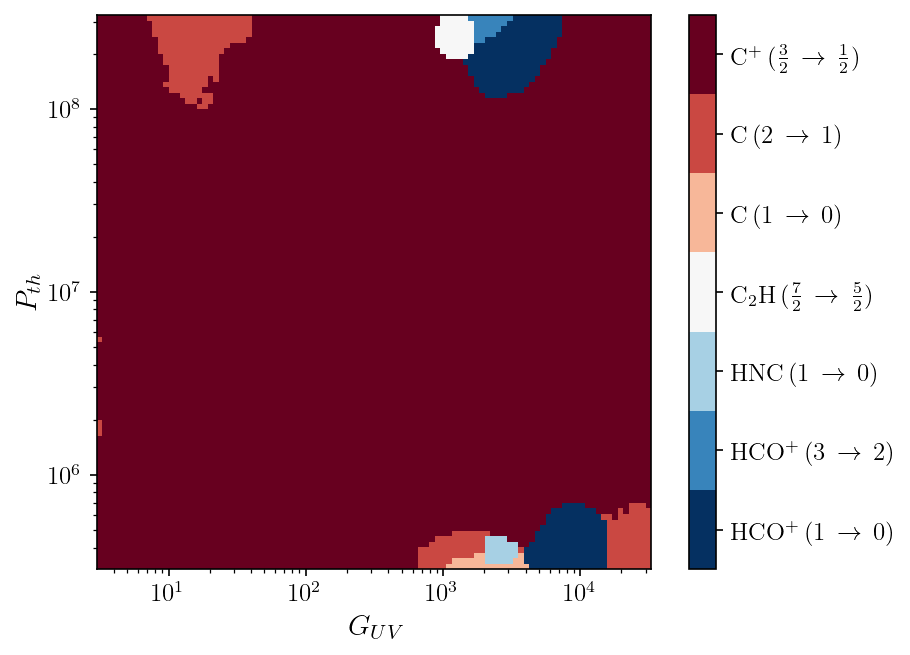

In [100]:
n = len(lines_list_short)
# cmap = colormaps.get('RdBu_r', n)

from matplotlib import cm
cmap = cm.get_cmap('RdBu_r', n)

plt.figure(figsize=(6.4, 4.8), dpi=150)

ax = plt.gca()

plt.pcolor(X, Y, res_mi_short, cmap=cmap, vmin=-0.5, vmax=n-0.5)

plt.xscale('log')
plt.yscale('log')

plt.xlabel(f"${latex_param(wins_features[1])}$", fontsize=labelfontsize)
plt.ylabel(f"${latex_param(wins_features[0])}$", fontsize=labelfontsize)

plt.xticks(fontsize=ticksfontsize)
plt.yticks(fontsize=ticksfontsize)

plt.gca().set_box_aspect(1)

cbar = plt.colorbar()
cbar.set_ticks(np.arange(n), labels=[f"${plotter.lines_comb_formatter(c)}$" for c in lines_list_short], fontsize=ticksfontsize)

plt.savefig(f"{param}_summary_map.png")
plt.show()